In [165]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from models.architectures.temperature_prediction.simple_model import ModelSimple
from models.architectures.temperature_prediction.model_v2 import Modelv2
from models.architectures.temperature_prediction.model_v3 import Modelv3
from models.architectures.temperature_prediction.model_v4 import Modelv4
from models.architectures.temperature_prediction.model_v5 import Modelv5
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import Dataset, DataLoader

In [166]:
df = pd.read_csv("Data/data_concatenated/Albuquerque_concatenated.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             45253 non-null  datetime64[ns]
 1   humidity             44543 non-null  float64       
 2   pressure             44797 non-null  float64       
 3   temperature          45252 non-null  float64       
 4   weather_description  45252 non-null  object        
 5   wind_direction       45252 non-null  float64       
 6   wind_speed           45249 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.4+ MB


In [167]:
df

,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,50.0,1024.0,285.120000,sky is clear,360.0,4.0
2,2012-10-01 14:00:00,49.0,1024.0,285.154558,sky is clear,360.0,4.0
3,2012-10-01 15:00:00,49.0,1024.0,285.233952,sky is clear,360.0,4.0
4,2012-10-01 16:00:00,49.0,1024.0,285.313345,sky is clear,360.0,4.0
...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,37.0,1025.0,285.720000,broken clouds,217.0,1.0
45249,2017-11-29 21:00:00,34.0,1024.0,286.450000,broken clouds,217.0,1.0
45250,2017-11-29 22:00:00,32.0,1024.0,286.440000,broken clouds,190.0,1.0
45251,2017-11-29 23:00:00,30.0,1024.0,286.140000,overcast clouds,200.0,1.0


<Axes: xlabel='hour', ylabel='temperature'>

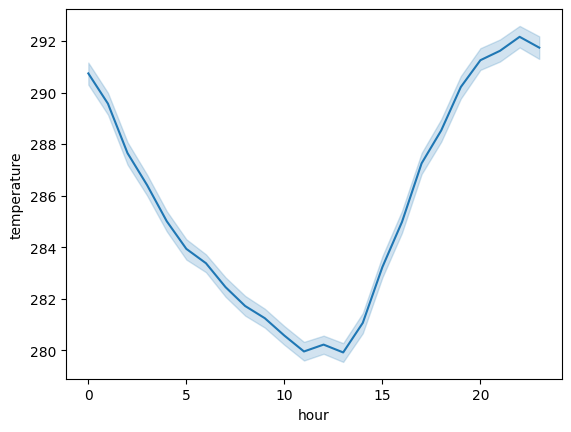

In [168]:
df["hour"] = df["datetime"].dt.hour
sns.lineplot(df, x="hour", y="temperature")

<Axes: xlabel='hour', ylabel='wind_speed'>

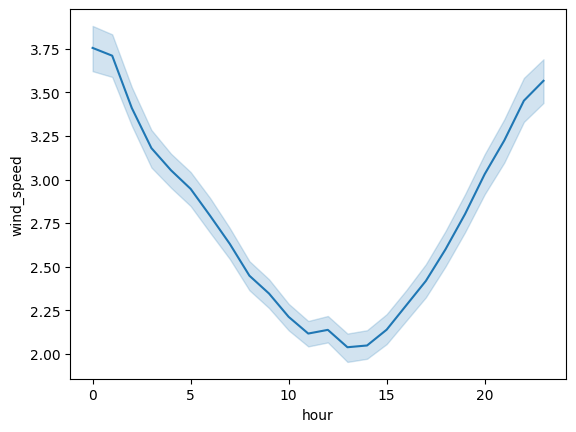

In [169]:
sns.lineplot(df, x="hour", y="wind_speed")

In [170]:
df["date"] = pd.to_datetime(df["datetime"].dt.date)
df

,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,hour,date
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,12,2012-10-01
1,2012-10-01 13:00:00,50.0,1024.0,285.120000,sky is clear,360.0,4.0,13,2012-10-01
2,2012-10-01 14:00:00,49.0,1024.0,285.154558,sky is clear,360.0,4.0,14,2012-10-01
3,2012-10-01 15:00:00,49.0,1024.0,285.233952,sky is clear,360.0,4.0,15,2012-10-01
4,2012-10-01 16:00:00,49.0,1024.0,285.313345,sky is clear,360.0,4.0,16,2012-10-01
...,...,...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,37.0,1025.0,285.720000,broken clouds,217.0,1.0,20,2017-11-29
45249,2017-11-29 21:00:00,34.0,1024.0,286.450000,broken clouds,217.0,1.0,21,2017-11-29
45250,2017-11-29 22:00:00,32.0,1024.0,286.440000,broken clouds,190.0,1.0,22,2017-11-29
45251,2017-11-29 23:00:00,30.0,1024.0,286.140000,overcast clouds,200.0,1.0,23,2017-11-29


In [171]:
cloud_cover_mapping = {
    "overcast clouds": 0.9,
    "broken clouds": 0.75,
    "scattered clouds": 0.4,
    "few clouds": 0.2,
    "sky is clear": 0.0
}
df['cloud_cover'] = df['weather_description'].map(cloud_cover_mapping).fillna(1.0)

precipitation_mapping = {
    "thunderstorm": 4.0,
    "thunderstorm with rain": 5.0,
    "proximity thunderstorm": 1.0,
    "light rain": 2.0,
    "moderate rain": 2.5,
    "shower rain": 3.0,
    "light intensity shower rain": 2.5,
    "heavy intensity rain": 4.5,
    "heavy snow": 4.0,
    "light snow": 2.0,
    "drizzle": 2.0,
    "light intensity drizzle": 1.5,
    "heavy intensity drizzle": 2.5
}

df['rain_cover'] = df['weather_description'].map(precipitation_mapping).fillna(0.0)

df

,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,hour,date,cloud_cover,rain_cover
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,12,2012-10-01,1.00,0.0
1,2012-10-01 13:00:00,50.0,1024.0,285.120000,sky is clear,360.0,4.0,13,2012-10-01,0.00,0.0
2,2012-10-01 14:00:00,49.0,1024.0,285.154558,sky is clear,360.0,4.0,14,2012-10-01,0.00,0.0
3,2012-10-01 15:00:00,49.0,1024.0,285.233952,sky is clear,360.0,4.0,15,2012-10-01,0.00,0.0
4,2012-10-01 16:00:00,49.0,1024.0,285.313345,sky is clear,360.0,4.0,16,2012-10-01,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45248,2017-11-29 20:00:00,37.0,1025.0,285.720000,broken clouds,217.0,1.0,20,2017-11-29,0.75,0.0
45249,2017-11-29 21:00:00,34.0,1024.0,286.450000,broken clouds,217.0,1.0,21,2017-11-29,0.75,0.0
45250,2017-11-29 22:00:00,32.0,1024.0,286.440000,broken clouds,190.0,1.0,22,2017-11-29,0.75,0.0
45251,2017-11-29 23:00:00,30.0,1024.0,286.140000,overcast clouds,200.0,1.0,23,2017-11-29,0.90,0.0


In [172]:
df = df.drop([df.index[0], df.index[-1]])
df = df.drop(columns=['weather_description'])
df = df.groupby(by="date").mean().drop(columns=["datetime"]).reset_index()
df

,date,humidity,pressure,temperature,wind_direction,wind_speed,hour,cloud_cover,rain_cover
0,2012-10-01,48.909091,1024.000000,285.476208,360.000000,4.000000,18.0,0.000000,0.0
1,2012-10-02,40.363636,1022.772727,289.771821,303.458333,3.166667,11.5,0.025000,0.0
2,2012-10-03,31.904762,1021.666667,291.205417,132.708333,2.958333,11.5,0.025000,0.0
3,2012-10-04,19.681818,1018.318182,293.096250,144.541667,1.916667,11.5,0.108333,0.0
4,2012-10-05,18.250000,1020.850000,292.829167,225.875000,2.583333,11.5,0.108333,0.0
...,...,...,...,...,...,...,...,...,...
1881,2017-11-25,31.416667,1021.958333,282.564583,211.375000,2.166667,11.5,0.200000,0.0
1882,2017-11-26,29.750000,1027.166667,282.211250,194.333333,1.541667,11.5,0.337500,0.0
1883,2017-11-27,29.041667,1021.250000,281.325833,168.458333,1.708333,11.5,0.287500,0.0
1884,2017-11-28,31.458333,1016.125000,283.251667,227.500000,3.708333,11.5,0.279167,0.0


<Axes: xlabel='day_of_year', ylabel='temperature'>

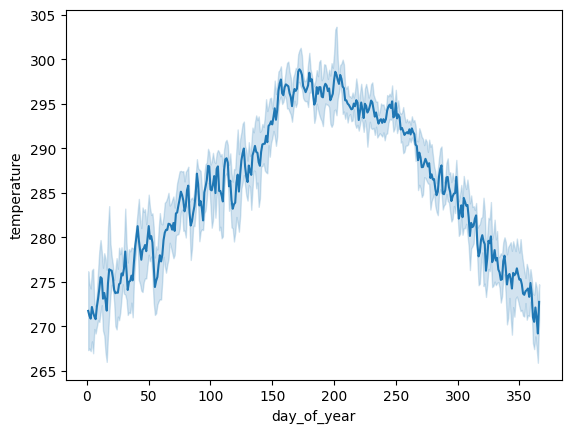

In [173]:
df["day_of_year"] = df["date"].dt.day_of_year
sns.lineplot(df, x="day_of_year", y="temperature")

<Axes: xlabel='wind_speed', ylabel='temperature'>

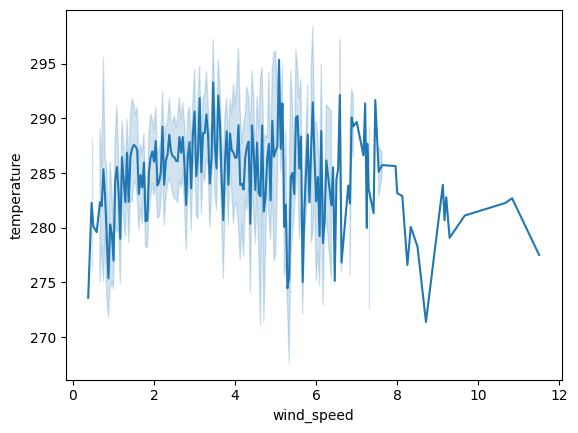

In [174]:
sns.lineplot(df, x="wind_speed", y="temperature")

<Axes: xlabel='humidity', ylabel='temperature'>

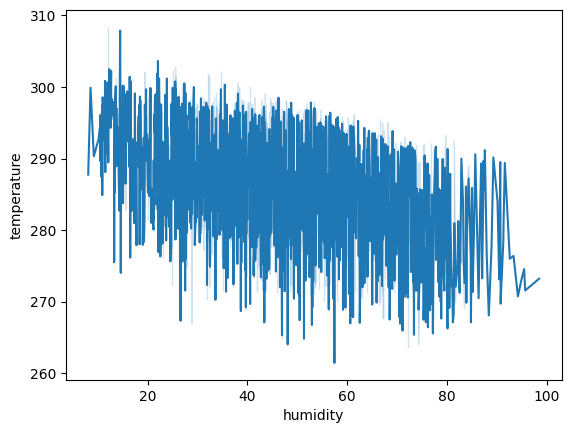

In [175]:
sns.lineplot(df, x="humidity", y="temperature")

<Axes: xlabel='day_of_year', ylabel='humidity'>

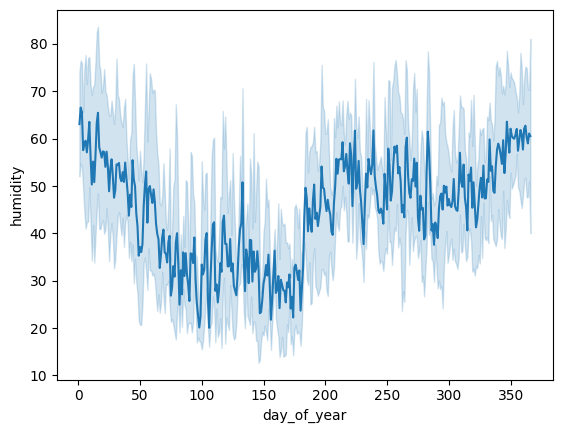

In [176]:
sns.lineplot(df, x="day_of_year", y="humidity")

<Axes: xlabel='day_of_year', ylabel='wind_speed'>

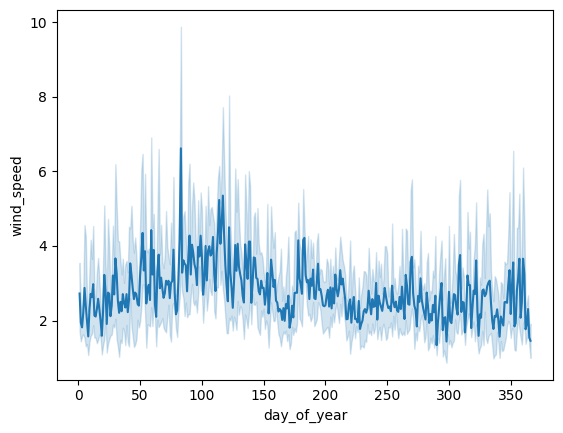

In [177]:
sns.lineplot(df, x="day_of_year", y="wind_speed")

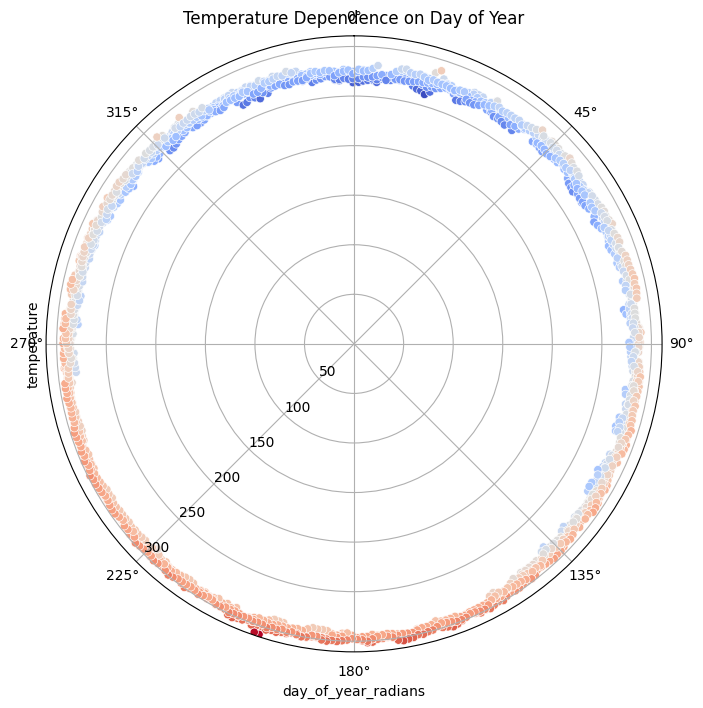

In [178]:
df["day_of_year_radians"] = 2 * np.pi * df["day_of_year"] / 365.25
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

sns.scatterplot(
    x=df['day_of_year_radians'], 
    y=df['temperature'], 
    hue=df['temperature'], 
    palette='coolwarm', 
    ax=ax, 
    legend=None
)

ax.set_theta_direction(-1)  
ax.set_theta_offset(np.pi / 2)  
ax.set_rlabel_position(225)
ax.set_title("Temperature Dependence on Day of Year", va='bottom')

plt.show()



<Axes: xlabel='day_of_year_sin', ylabel='day_of_year_cos'>

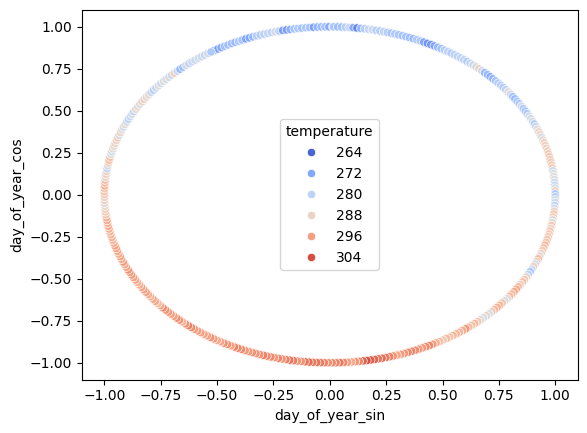

In [179]:
df['day_of_year_sin'] = np.sin(df["day_of_year_radians"])
df['day_of_year_cos'] = np.cos(df["day_of_year_radians"])

sns.scatterplot(df, x="day_of_year_sin", y="day_of_year_cos", hue="temperature", palette='coolwarm', )

In [180]:
df

,date,humidity,pressure,temperature,wind_direction,wind_speed,hour,cloud_cover,rain_cover,day_of_year,day_of_year_radians,day_of_year_sin,day_of_year_cos
0,2012-10-01,48.909091,1024.000000,285.476208,360.000000,4.000000,18.0,0.000000,0.0,275,4.730667,-0.999833,0.018277
1,2012-10-02,40.363636,1022.772727,289.771821,303.458333,3.166667,11.5,0.025000,0.0,276,4.747869,-0.999371,0.035473
2,2012-10-03,31.904762,1021.666667,291.205417,132.708333,2.958333,11.5,0.025000,0.0,277,4.765071,-0.998613,0.052658
3,2012-10-04,19.681818,1018.318182,293.096250,144.541667,1.916667,11.5,0.108333,0.0,278,4.782274,-0.997559,0.069828
4,2012-10-05,18.250000,1020.850000,292.829167,225.875000,2.583333,11.5,0.108333,0.0,279,4.799476,-0.996210,0.086977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,2017-11-25,31.416667,1021.958333,282.564583,211.375000,2.166667,11.5,0.200000,0.0,329,5.659597,-0.583951,0.811789
1882,2017-11-26,29.750000,1027.166667,282.211250,194.333333,1.541667,11.5,0.337500,0.0,330,5.676800,-0.569901,0.821713
1883,2017-11-27,29.041667,1021.250000,281.325833,168.458333,1.708333,11.5,0.287500,0.0,331,5.694002,-0.555682,0.831395
1884,2017-11-28,31.458333,1016.125000,283.251667,227.500000,3.708333,11.5,0.279167,0.0,332,5.711205,-0.541298,0.840831


In [181]:
df_proposition = df
df_proposition = df_proposition.drop(columns = ['day_of_year', 'day_of_year_radians', 'hour', 'date', 'wind_direction', ])
df_proposition



,humidity,pressure,temperature,wind_speed,cloud_cover,rain_cover,day_of_year_sin,day_of_year_cos
0,48.909091,1024.000000,285.476208,4.000000,0.000000,0.0,-0.999833,0.018277
1,40.363636,1022.772727,289.771821,3.166667,0.025000,0.0,-0.999371,0.035473
2,31.904762,1021.666667,291.205417,2.958333,0.025000,0.0,-0.998613,0.052658
3,19.681818,1018.318182,293.096250,1.916667,0.108333,0.0,-0.997559,0.069828
4,18.250000,1020.850000,292.829167,2.583333,0.108333,0.0,-0.996210,0.086977
...,...,...,...,...,...,...,...,...
1881,31.416667,1021.958333,282.564583,2.166667,0.200000,0.0,-0.583951,0.811789
1882,29.750000,1027.166667,282.211250,1.541667,0.337500,0.0,-0.569901,0.821713
1883,29.041667,1021.250000,281.325833,1.708333,0.287500,0.0,-0.555682,0.831395
1884,31.458333,1016.125000,283.251667,3.708333,0.279167,0.0,-0.541298,0.840831


In [182]:
df_proposition = df_proposition
df_proposition = df_proposition.drop(columns = ['wind_speed','humidity','pressure'])
df_proposition

,temperature,cloud_cover,rain_cover,day_of_year_sin,day_of_year_cos
0,285.476208,0.000000,0.0,-0.999833,0.018277
1,289.771821,0.025000,0.0,-0.999371,0.035473
2,291.205417,0.025000,0.0,-0.998613,0.052658
3,293.096250,0.108333,0.0,-0.997559,0.069828
4,292.829167,0.108333,0.0,-0.996210,0.086977
...,...,...,...,...,...
1881,282.564583,0.200000,0.0,-0.583951,0.811789
1882,282.211250,0.337500,0.0,-0.569901,0.821713
1883,281.325833,0.287500,0.0,-0.555682,0.831395
1884,283.251667,0.279167,0.0,-0.541298,0.840831


In [183]:
df_proposition['target_temperature'] = df_proposition['temperature'].shift(-4)
df_proposition

,temperature,cloud_cover,rain_cover,day_of_year_sin,day_of_year_cos,target_temperature
0,285.476208,0.000000,0.0,-0.999833,0.018277,292.829167
1,289.771821,0.025000,0.0,-0.999371,0.035473,292.885417
2,291.205417,0.025000,0.0,-0.998613,0.052658,288.764792
3,293.096250,0.108333,0.0,-0.997559,0.069828,281.987500
4,292.829167,0.108333,0.0,-0.996210,0.086977,284.581667
...,...,...,...,...,...,...
1881,282.564583,0.200000,0.0,-0.583951,0.811789,277.646250
1882,282.211250,0.337500,0.0,-0.569901,0.821713,NaN
1883,281.325833,0.287500,0.0,-0.555682,0.831395,NaN
1884,283.251667,0.279167,0.0,-0.541298,0.840831,NaN


In [184]:
features_to_expand = ['cloud_cover','temperature', 'rain_cover']

for feature in features_to_expand:
    df_proposition[f'{feature}_1'] = df_proposition[feature]
    df_proposition[f'{feature}_2'] = df_proposition[feature].shift(-1)
    df_proposition[f'{feature}_3'] = df_proposition[feature].shift(-2)

df_proposition = df_proposition.drop(columns=features_to_expand)

df_proposition = df_proposition[:-4]

df_proposition

,day_of_year_sin,day_of_year_cos,target_temperature,cloud_cover_1,cloud_cover_2,cloud_cover_3,temperature_1,temperature_2,temperature_3,rain_cover_1,rain_cover_2,rain_cover_3
0,-0.999833,0.018277,292.829167,0.000000,0.025000,0.025000,285.476208,289.771821,291.205417,0.0,0.0,0.0
1,-0.999371,0.035473,292.885417,0.025000,0.025000,0.108333,289.771821,291.205417,293.096250,0.0,0.0,0.0
2,-0.998613,0.052658,288.764792,0.025000,0.108333,0.108333,291.205417,293.096250,292.829167,0.0,0.0,0.0
3,-0.997559,0.069828,281.987500,0.108333,0.108333,0.325000,293.096250,292.829167,292.885417,0.0,0.0,0.0
4,-0.996210,0.086977,284.581667,0.108333,0.325000,0.387500,292.829167,292.885417,288.764792,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1877,-0.638384,0.769718,282.564583,0.725000,0.479167,0.429167,282.752083,280.648750,281.507083,0.0,0.0,0.0
1878,-0.625050,0.780585,282.211250,0.479167,0.429167,0.293750,280.648750,281.507083,281.715417,0.0,0.0,0.0
1879,-0.611530,0.791221,281.325833,0.429167,0.293750,0.200000,281.507083,281.715417,282.564583,0.0,0.0,0.0
1880,-0.597829,0.801624,283.251667,0.293750,0.200000,0.337500,281.715417,282.564583,282.211250,0.0,0.0,0.0


In [185]:

scaler = MinMaxScaler()

normalized_df = pd.DataFrame(scaler.fit_transform(df_proposition), columns=df_proposition.columns)
normalized_df

,day_of_year_sin,day_of_year_cos,target_temperature,cloud_cover_1,cloud_cover_2,cloud_cover_3,temperature_1,temperature_2,temperature_3,rain_cover_1,rain_cover_2,rain_cover_3
0,0.000083,0.509136,0.668474,0.000000,0.025000,0.025000,0.511797,0.603328,0.633875,0.0,0.0,0.0
1,0.000314,0.517734,0.669672,0.025000,0.025000,0.108333,0.603328,0.633875,0.674165,0.0,0.0,0.0
2,0.000693,0.526327,0.581870,0.025000,0.108333,0.108333,0.633875,0.674165,0.668474,0.0,0.0,0.0
3,0.001220,0.534912,0.437460,0.108333,0.108333,0.325000,0.674165,0.668474,0.669672,0.0,0.0,0.0
4,0.001895,0.543486,0.492737,0.108333,0.325000,0.387500,0.668474,0.669672,0.581870,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1877,0.180809,0.884862,0.449757,0.725000,0.479167,0.429167,0.453752,0.408934,0.427224,0.0,0.0,0.0
1878,0.187476,0.890295,0.442228,0.479167,0.429167,0.293750,0.408934,0.427224,0.431663,0.0,0.0,0.0
1879,0.194236,0.895614,0.423362,0.429167,0.293750,0.200000,0.427224,0.431663,0.449757,0.0,0.0,0.0
1880,0.201087,0.900815,0.464397,0.293750,0.200000,0.337500,0.431663,0.449757,0.442228,0.0,0.0,0.0


In [186]:
class WeatherDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [187]:
data = normalized_df.drop(columns=['target_temperature']).to_numpy()
targets = normalized_df['target_temperature'].to_numpy()

# Split data into training and testing
train_data, test_data = data[:1400], data[1400:]
train_targets, test_targets = targets[:1400], targets[1400:]

# Create dataset and data loaders
train_dataset = WeatherDataset(train_data, train_targets)
test_dataset = WeatherDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

ModelSimple

Model v2

In [188]:
input_size = data.shape[1] 

model = Modelv2(input_size=input_size, learning_rate=0.0001)

model.train_model(train_loader, epochs=60)

model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)

absolute_differences = torch.tensor(absolute_differences)

print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/60, Loss: 0.1249
Epoch 10/60, Loss: 0.0053
Epoch 20/60, Loss: 0.0047
Epoch 30/60, Loss: 0.0046
Epoch 40/60, Loss: 0.0045
Epoch 50/60, Loss: 0.0044
Epoch 60/60, Loss: 0.0043
Test Loss: 0.0046
Mean Absolute Difference: 2.62497790493256


In [189]:

input_size = data.shape[1] 

model = Modelv3(input_size=input_size, learning_rate=0.0001)


model.train_model(train_loader, epochs=100)

model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)

absolute_differences = torch.tensor(absolute_differences)

# Print summary
print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/100, Loss: 0.4208
Epoch 10/100, Loss: 0.0056
Epoch 20/100, Loss: 0.0049
Epoch 30/100, Loss: 0.0046
Epoch 40/100, Loss: 0.0045
Epoch 50/100, Loss: 0.0044
Epoch 60/100, Loss: 0.0043
Epoch 70/100, Loss: 0.0043
Epoch 80/100, Loss: 0.0042
Epoch 90/100, Loss: 0.0041
Epoch 100/100, Loss: 0.0041
Test Loss: 0.0050
Mean Absolute Difference: 2.7063408984127646


In [190]:

input_size = data.shape[1] 


model = Modelv4(input_size=input_size)


model.train_model(train_loader, epochs=30)


model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)

absolute_differences = torch.tensor(absolute_differences)

print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/30, Loss: 0.0878
Epoch 10/30, Loss: 0.0047
Epoch 20/30, Loss: 0.0042
Epoch 30/30, Loss: 0.0042
Test Loss: 0.0046
Mean Absolute Difference: 2.5723026624824374


Tylko temperatura

In [191]:
df_only_temperature = df
df_only_temperature = df_only_temperature.drop(columns = ['day_of_year', 'day_of_year_radians', 'hour', 'date', 'wind_direction', 'wind_speed', 'pressure', 'humidity', 'cloud_cover' , 'rain_cover' ])
df_only_temperature['target_temperature'] = df_only_temperature['temperature'].shift(-4)
features_to_expand = ['temperature']

for feature in features_to_expand:
    df_only_temperature[f'{feature}_1'] = df_only_temperature[feature]
    df_only_temperature[f'{feature}_2'] = df_only_temperature[feature].shift(-1)
    df_only_temperature[f'{feature}_3'] = df_only_temperature[feature].shift(-2)

df_only_temperature = df_only_temperature.drop(columns=features_to_expand)

df_only_temperature = df_only_temperature[:-4]

scaler = MinMaxScaler()

df_only_temperature = pd.DataFrame(scaler.fit_transform(df_only_temperature), columns=df_only_temperature.columns)

df_only_temperature

,day_of_year_sin,day_of_year_cos,target_temperature,temperature_1,temperature_2,temperature_3
0,0.000083,0.509136,0.668474,0.511797,0.603328,0.633875
1,0.000314,0.517734,0.669672,0.603328,0.633875,0.674165
2,0.000693,0.526327,0.581870,0.633875,0.674165,0.668474
3,0.001220,0.534912,0.437460,0.674165,0.668474,0.669672
4,0.001895,0.543486,0.492737,0.668474,0.669672,0.581870
...,...,...,...,...,...,...
1877,0.180809,0.884862,0.449757,0.453752,0.408934,0.427224
1878,0.187476,0.890295,0.442228,0.408934,0.427224,0.431663
1879,0.194236,0.895614,0.423362,0.427224,0.431663,0.449757
1880,0.201087,0.900815,0.464397,0.431663,0.449757,0.442228


In [192]:
data_only_temp = df_only_temperature.drop(columns=['target_temperature']).to_numpy()
targets_only_temp = df_only_temperature['target_temperature'].to_numpy()


train_data, test_data = data_only_temp[:1400], data_only_temp[1400:]
train_targets, test_targets = targets_only_temp[:1400], targets_only_temp[1400:]


train_dataset = WeatherDataset(train_data, train_targets)
test_dataset = WeatherDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

input_size = data_only_temp.shape[1] 


model = Modelv5(input_size=input_size)

model.train_model(train_loader, epochs=30)

model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)


absolute_differences = torch.tensor(absolute_differences)

print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/30, Loss: 0.1540
Epoch 10/30, Loss: 0.0053
Epoch 20/30, Loss: 0.0050
Epoch 30/30, Loss: 0.0048
Test Loss: 0.0054
Mean Absolute Difference: 2.834314038079709


Tylko temperatura z różnicą


In [193]:
df_diff_temperature = df
df_diff_temperature = df_diff_temperature.drop(columns = ['day_of_year', 'day_of_year_radians', 'hour', 'date', 'wind_direction', 'wind_speed', 'pressure', 'humidity', 'cloud_cover', 'rain_cover' ])
df_diff_temperature['target_temperature'] = df_diff_temperature['temperature'].shift(-4)
features_to_expand = ['temperature']

for feature in features_to_expand:
    df_diff_temperature[f'{feature}_1'] = df_diff_temperature[feature]
    df_diff_temperature[f'{feature}_2'] = df_diff_temperature[feature].shift(-1) 
    df_diff_temperature[f'{feature}_3'] = df_diff_temperature[feature].shift(-2)
    df_diff_temperature[f'{feature}_2'] = df_diff_temperature[f'{feature}_2'] - df_diff_temperature[f'{feature}_3']
    df_diff_temperature[f'{feature}_1'] = df_diff_temperature[f'{feature}_1'] - df_diff_temperature[f'{feature}_3']


df_diff_temperature = df_diff_temperature.drop(columns=features_to_expand)

df_diff_temperature = df_diff_temperature[:-4]

scaler = MinMaxScaler()

df_diff_temperature = pd.DataFrame(scaler.fit_transform(df_diff_temperature), columns=df_diff_temperature.columns)

df_diff_temperature


,day_of_year_sin,day_of_year_cos,target_temperature,temperature_1,temperature_2,temperature_3
0,0.000083,0.509136,0.668474,0.232609,0.265340,0.633875
1,0.000314,0.517734,0.669672,0.321247,0.245260,0.674165
2,0.000693,0.526327,0.581870,0.383933,0.340029,0.668474
3,0.001220,0.534912,0.437460,0.451553,0.325830,0.669672
4,0.001895,0.543486,0.492737,0.593591,0.509267,0.581870
...,...,...,...,...,...,...
1877,0.180809,0.884862,0.449757,0.489672,0.290604,0.427224
1878,0.187476,0.890295,0.442228,0.404466,0.319150,0.431663
1879,0.194236,0.895614,0.423362,0.404804,0.291007,0.449757
1880,0.201087,0.900815,0.464397,0.425506,0.343817,0.442228


In [194]:
data_diff_temp = df_diff_temperature.drop(columns=['target_temperature']).to_numpy()
targets_diff_temp = df_diff_temperature['target_temperature'].to_numpy()

train_data, test_data = data_diff_temp[:1400], data_diff_temp[1400:]
train_targets, test_targets = targets_diff_temp[:1400], targets_diff_temp[1400:]


train_dataset = WeatherDataset(train_data, train_targets)
test_dataset = WeatherDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


input_size = data_diff_temp.shape[1] 


model = Modelv2(input_size=input_size)


model.train_model(train_loader, epochs=50)

model.test_model(test_loader)

absolute_differences = []
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

for row_idx in range(len(test_data)):
    prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))

    unnormalized_prediction = prediction * (max_value - min_value) + min_value
    unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value
    
    absolute_difference = abs(unnormalized_prediction - unnormalized_target)
    absolute_differences.append(absolute_difference)


absolute_differences = torch.tensor(absolute_differences)

print(f"Mean Absolute Difference: {torch.mean(absolute_differences)}")

Epoch 1/50, Loss: 0.0303
Epoch 10/50, Loss: 0.0047
Epoch 20/50, Loss: 0.0046
Epoch 30/50, Loss: 0.0045
Epoch 40/50, Loss: 0.0045
Epoch 50/50, Loss: 0.0045
Test Loss: 0.0058
Mean Absolute Difference: 2.972509056627048


Więcej cech z wykorzystaniem różnicy

In [195]:
df_diff_more = df
df_diff_more = df_diff_more.drop(columns = ['day_of_year', 'day_of_year_radians', 'hour', 'date', 'wind_direction', 'wind_speed'])
df_diff_more['target_temperature'] = df_diff_more['temperature'].shift(-4)
features_to_expand = ['temperature', 'humidity', 'rain_cover', 'cloud_cover', 'pressure' ]

for feature in features_to_expand:
    df_diff_more[f'{feature}_1'] = df_diff_more[feature]
    df_diff_more[f'{feature}_2'] = df_diff_more[feature].shift(-1) 
    df_diff_more[f'{feature}_3'] = df_diff_more[feature].shift(-2)
    df_diff_more[f'{feature}_2'] = df_diff_more[f'{feature}_2'] - df_diff_more[f'{feature}_3']
    df_diff_more[f'{feature}_1'] = df_diff_more[f'{feature}_1'] - df_diff_more[f'{feature}_3']

df_diff_more = df_diff_more.drop(columns=features_to_expand)

df_diff_more = df_diff_more[:-4]

scaler = MinMaxScaler()

df_diff_more = pd.DataFrame(scaler.fit_transform(df_diff_more), columns=df_diff_more.columns)

df_diff_more

,day_of_year_sin,day_of_year_cos,target_temperature,temperature_1,temperature_2,temperature_3,humidity_1,humidity_2,humidity_3,rain_cover_1,rain_cover_2,rain_cover_3,cloud_cover_1,cloud_cover_2,cloud_cover_3,pressure_1,pressure_2,pressure_3
0,0.000083,0.509136,0.668474,0.232609,0.265340,0.633875,0.655460,0.588549,0.263327,0.408163,0.527273,0.0,0.481013,0.491525,0.025000,0.509854,0.539031,0.875365
1,0.000314,0.517734,0.669672,0.321247,0.245260,0.674165,0.687473,0.624990,0.128117,0.408163,0.527273,0.0,0.451477,0.449153,0.108333,0.515268,0.545086,0.860303
2,0.000693,0.526327,0.581870,0.383933,0.340029,0.668474,0.626302,0.520518,0.112279,0.408163,0.527273,0.0,0.451477,0.491525,0.108333,0.505983,0.529208,0.871692
3,0.001220,0.534912,0.437460,0.451553,0.325830,0.669672,0.511298,0.497090,0.123209,0.408163,0.527273,0.0,0.383966,0.381356,0.325000,0.498795,0.537480,0.869300
4,0.001895,0.543486,0.492737,0.593591,0.509267,0.581870,0.407800,0.405413,0.238890,0.408163,0.527273,0.0,0.352321,0.459746,0.387500,0.548392,0.581683,0.793275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,0.180809,0.884862,0.449757,0.489672,0.290604,0.427224,0.261153,0.494554,0.381914,0.408163,0.527273,0.0,0.643460,0.516949,0.429167,0.491245,0.540657,0.897668
1878,0.187476,0.890295,0.442228,0.404466,0.319150,0.431663,0.473703,0.481242,0.410951,0.408163,0.527273,0.0,0.587553,0.560381,0.293750,0.524529,0.553259,0.868993
1879,0.194236,0.895614,0.423362,0.404804,0.291007,0.449757,0.605005,0.640581,0.257928,0.408163,0.527273,0.0,0.609705,0.539195,0.200000,0.515809,0.531431,0.876677
1880,0.201087,0.900815,0.464397,0.425506,0.343817,0.442228,0.642365,0.522791,0.239491,0.408163,0.527273,0.0,0.471519,0.421610,0.337500,0.486247,0.521980,0.900105


In [196]:
data_diff_more = df_diff_more.drop(columns=['target_temperature']).to_numpy()
targets_diff_more = df_diff_more['target_temperature'].to_numpy()

train_data, test_data = data_diff_more[:1400], data_diff_more[1400:]
train_targets, test_targets = targets_diff_more[:1400], targets_diff_more[1400:]

train_dataset = WeatherDataset(train_data, train_targets)
test_dataset = WeatherDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

input_size = data_diff_more.shape[1] 
max_value = df_proposition['target_temperature'].max()
min_value = df_proposition['target_temperature'].min()

learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.05]

lr_mae_list = []
for lr in learning_rates:
    mae_list = []
    for run in range(10):
        absolute_differences = []
        model = Modelv2(input_size=input_size, learning_rate=lr)

        model.train_model(train_loader, epochs=50)


        model.test_model(test_loader)
        
        for row_idx in range(len(test_data)):
            prediction = model.predict(torch.tensor(test_data[row_idx], dtype=torch.float32).unsqueeze(0))


            unnormalized_prediction = prediction * (max_value - min_value) + min_value
            unnormalized_target = test_targets[row_idx] * (max_value - min_value) + min_value

            absolute_difference = abs(unnormalized_prediction - unnormalized_target)
            absolute_differences.append(absolute_difference)

        absolute_differences = torch.tensor(absolute_differences)
        mae = torch.mean(absolute_differences)
        mae_list.append(mae)

        print(f"Run {run + 1}: Mean Absolute Difference = {mae.item()}")


    mean_mae_across_runs = torch.mean(torch.tensor(mae_list))
    min_mae_across_runs = torch.min(torch.tensor(mae_list))
    lr_mae_list.append(mean_mae_across_runs)

    print(f"Mean of Mean Absolute Errors (MAEs) across 10 runs: {mean_mae_across_runs.item()}")
    print(f"Min of Mean Absolute Errors (MAEs) across 10 runs: {min_mae_across_runs.item()}")

min_mae_across_lr = min(lr_mae_list)
lr_index = lr_mae_list.index(min_mae_across_lr)

print(f"Best Mean Absolute Error across learning rates: {min_mae_across_lr}, for learning rate: {lr_index}")


Epoch 1/50, Loss: 0.2515
Epoch 10/50, Loss: 0.1641
Epoch 20/50, Loss: 0.0797
Epoch 30/50, Loss: 0.0348
Epoch 40/50, Loss: 0.0260
Epoch 50/50, Loss: 0.0201
Test Loss: 0.0163
Run 1: Mean Absolute Difference = 5.045363140949448
Epoch 1/50, Loss: 0.7583
Epoch 10/50, Loss: 0.4911
Epoch 20/50, Loss: 0.1991
Epoch 30/50, Loss: 0.0625
Epoch 40/50, Loss: 0.0496
Epoch 50/50, Loss: 0.0428
Test Loss: 0.0353
Run 2: Mean Absolute Difference = 7.52461857654139
Epoch 1/50, Loss: 0.1522
Epoch 10/50, Loss: 0.1316
Epoch 20/50, Loss: 0.1262
Epoch 30/50, Loss: 0.1212
Epoch 40/50, Loss: 0.1163
Epoch 50/50, Loss: 0.1116
Test Loss: 0.1308
Run 3: Mean Absolute Difference = 15.218374512596315
Epoch 1/50, Loss: 0.4149
Epoch 10/50, Loss: 0.3447
Epoch 20/50, Loss: 0.2981
Epoch 30/50, Loss: 0.2892
Epoch 40/50, Loss: 0.2807
Epoch 50/50, Loss: 0.2722
Test Loss: 0.3113
Run 4: Mean Absolute Difference = 25.043846098730846
Epoch 1/50, Loss: 0.3044
Epoch 10/50, Loss: 0.2204
Epoch 20/50, Loss: 0.1167
Epoch 30/50, Loss: 0.0